In [1]:
## Import packages
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

from scipy import fftpack
from scipy.signal import find_peaks
import matplotlib.patheffects as pe

from matplotlib.animation import FuncAnimation
import math
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
font_size = 14



In [2]:
## Dimensional operators
cav_dim = 2 # total number of possible photons
atm_dim = 2 # energy levels in atom, 2 for TLS
I_cav = qeye(cav_dim) # identity matrix matching dimension of radiation field (2, one for vacuum state, one for excited states)
I_atom = qeye(atm_dim) # identity matrix matching dimension of spin system

## Total atomic operators
sigmap_tot = tensor(sigmap(), I_cav)
sigmam_tot = tensor(sigmam(), I_cav)
sigmaz_tot = tensor(sigmaz(), I_cav)

## Photon operators
adag = create(cav_dim)
a = destroy(cav_dim)
adag_tot = tensor(I_atom, adag) # order of arguments is important and is consistant with the spin operators #add .unit()               
a_tot = tensor(I_atom, a)

## Physical constants
N = 7e14 # number of two-level systems
wa = 2 * np.pi * 1.45e3 # atom transition frequency between levels X & Z (MHz) allows is to work in micro seconds
wc = 2 * np.pi * 1.45e3 # cavity frequency with vacuum field energy set to zero (zero-point energy) (MHz)
gs = 2 * np.pi * 0.042e-6 # collective spin-photon couling strength ~ np.sqrt(tls_num)*g, experimentally it's 1.1 though.
g = 1.5 #2 * np.pi * 1.1 # test spin-photon couling strength ~ np.sqrt(tls_num)*gs, experimetnally it's 1.1 though.

Kc = 0 # 2 * np.pi * 0.18 # cavity mode decay rate (MHz) # derivation can be found in Agarwal pg.31
Ks = 0 #2 * np.pi * 0.11 # spin dephasing rate (MHz)
gamma = 0.2 # 2 * np.pi * 0.0177 # spin-lattice relaxation rate between X and Z

## Initial quantum states
psi_atm = np.sqrt(0)*basis(2,0) + np.sqrt(1)*basis(2,1) # atom begins in ground state
rho_atm = ket2dm(psi_atm)
psi_phot = np.sqrt(1)*fock(cav_dim, 1)
rho_phot = ket2dm(psi_phot)
psi0 = tensor(psi_atm, psi_phot)
rho = tensor(rho_atm, rho_phot)

## Simulation initialization
time = 20
steps = 2000
tlist = np.linspace(0, time, steps) # duration and steps to be used in evolution
step_size = tlist[1] - tlist[0]


In [3]:
""" Explicit Method """

## Observable initialization
n_phot_list = [((adag * a) * rho.ptrace(1)).tr()] # number of photons in light field
inver13_list = [(sigmaz() * rho.ptrace(0)).tr()] # population inversion operator 
spin_spin13_list = [((sigmap() * sigmam()) * rho.ptrace(0)).tr()] # spin-spin correlation
spin13_phot_list = [((adag_tot * sigmam_tot) * rho).tr()] # spin-photon correlation

# Tuneable parameters
use_rwa = True # set = True to use Rotating Wave Approximation
n_th = 0 # avg number of thermal bath excitation (nhf=kT)

## function computing the Lindblad master equation
def lindblad(p):
    
    ## Assembling the Hamiltonian
    HA = 0.5 * wa * sigmaz_tot # atomic part
    HF = wc * adag_tot * a_tot # field part

    if use_rwa:
        HI = sigmap_tot*a_tot + sigmam_tot*adag_tot # interaction part in the RWA
    else:
        HI = hbar * ((sigmap_tot + sigmam_tot)*(a_tot + adag_tot)) # interaction part not using RWA

    H = HA + HF + g*HI
    
    ## Liouvillian
    closed_system = -1j * commutator(H,p)
    cavity_decay = Kc/2 * (adag_tot*a_tot*p - 2*a_tot*p*adag_tot + p*adag_tot*a_tot)
    spin_relax = gamma/2 * (sigmap_tot*sigmam_tot*p - 2*sigmam_tot*p*sigmap_tot + p*sigmap_tot*sigmam_tot)
    spin_dephase = Ks/2 * (sigmaz_tot.dag()*sigmaz_tot*rho - 2*sigmaz_tot*rho*sigmaz_tot.dag() + rho*sigmaz_tot.dag()*sigmaz_tot)
    
    return closed_system - cavity_decay - spin_relax - spin_dephase



## RK4 method realized using a for loop
for step_index in range(steps-1):
    
    ## RK4 method
    k1 = step_size * lindblad(rho)
    k2 = step_size * lindblad(rho + 0.5*k1)
    k3 = step_size * lindblad(rho + 0.5*k2)
    k4 = step_size * lindblad(rho + k3)
    rho += 1/6*k1 + 1/3*(k2+k3) + 1/6*k4      # calculation of density matrix at n+1 step
    
#     #RK2 method
#     rho_pred = rho + 3/4 * lindblad(rho, N) * step_size # Predictor
#     rho_dash = rho_pred - 5/12 * lindblad(rho, N) * step_size
#     rho = rho_dash + 2/3 * lindblad(rho, N) * step_size # Corrector
    
    
    ## calculating observables at n+1 step using density matrix found above and adding them to list 
    n_phot_new = (((adag*a) * rho.ptrace(1)).tr().real)
    n_phot_list = np.append(n_phot_list, n_phot_new)
    
    inver13_new = (sigmaz() * rho.ptrace(0)).tr().real
    inver13_list = np.append(inver13_list, inver13_new)
    
    spin_spin13_new = ((sigmap() * sigmam()) * rho.ptrace(0)).tr().real
    spin_spin13_list = np.append(spin_spin13_list, spin_spin13_new)
    
    spin13_phot_new = ((adag_tot * sigmam_tot) * rho).tr().imag
    spin13_phot_list = np.append(spin13_phot_list, spin13_phot_new)
    

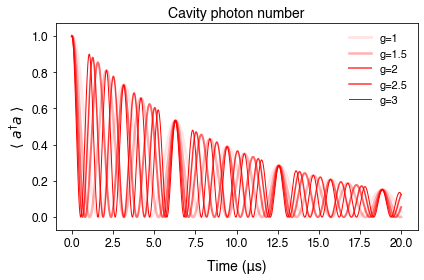

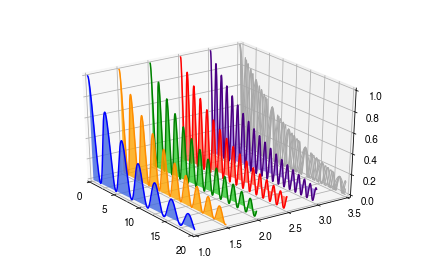

In [4]:
"""mesolve method"""

# Tuneable parameters
use_rwa = True # set = True to use Rotating Wave Approximation
n_th = 0 # avg number of thermal bath excitation (nhf=kT)

## Assembling the Hamiltonian

results = []

for lam in [1, 1.5, 2, 2.5, 3]:

    HA = 0.5 * wa * sigmaz_tot # atomic part
    HF = wc * adag_tot * a_tot # field part
    if use_rwa:
        HI = sigmap_tot*a_tot + sigmam_tot*adag_tot # interaction part in the RWA
    else:
        HI = (sigmap_tot + sigmam_tot)*(a_tot + adag_tot) # interaction part not using RWA
    H = HA + HF + lam*HI
   
    c_ops = []
    if n_th == 0.0:
        c_ops.append(np.sqrt(Kc) * a_tot) # cavity relaxation at absolute zero 
    else:
        c_ops.append(np.sqrt(Kc * n_th) * a_tot) # cavity excitation, if temperature > 0               

    c_ops.append(np.sqrt(gamma) * sigmam_tot) # spin relaxation
    c_ops.append(np.sqrt(Ks) * sigmaz_tot) # spin dephasing

    result = mesolve(H, psi0, tlist, c_ops, [adag_tot*a_tot, sigmaz_tot, sigmap_tot*sigmam_tot, adag_tot*sigmam_tot], options=Options(nsteps=10000))
    results.append(result)

    
plt.figure(figsize=(6,4))
plt.figure(1)
plt.plot(tlist, results[0].expect[0], color='r', linestyle='-', linewidth=3, alpha=0.1, label='g=1')
plt.plot(tlist, results[1].expect[0], color='r', linestyle='-', linewidth=2.5, alpha=0.3, label='g=1.5')
plt.plot(tlist, results[2].expect[0], color='r', linestyle='-', linewidth=2, alpha=0.6, label='g=2')
plt.plot(tlist, results[3].expect[0], color='r', linestyle='-', linewidth=1.5, alpha=0.8, label='g=2.5')
plt.plot(tlist, results[4].expect[0], color='r', linestyle='-', linewidth=1, alpha=1, label='g=3')
plt.ylim([-0.07, 1.07])
plt.title('Cavity photon number', fontsize = 14)
plt.ylabel(r'$\langle\ a^\dag a \ \rangle$', fontsize = 14)
plt.xlabel('Time (μs)', labelpad = 10, fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xticks(np.arange(0, time+1, 2.5))
plt.legend(fancybox=False, edgecolor='w', fontsize=11)
plt.tight_layout()
plt.savefig('adag a.png', format = 'png', dpi = 900) 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

z = np.zeros(tlist.shape)
verts1 = [(tlist[i],1,results[0].expect[0][i]) for i in range(len(tlist))] + [(0,1,0),(0,1,0)]
verts2 = [(tlist[i],1.5,results[1].expect[0][i]) for i in range(len(tlist))] + [(0,1.5,0),(0,1.5,0)]
verts3 = [(tlist[i],2,results[2].expect[0][i]) for i in range(len(tlist))] + [(0,2,0),(0,2,0)]
verts4 = [(tlist[i],2.5,results[3].expect[0][i]) for i in range(len(tlist))] + [(0,2.5,0),(0,2.5,0)]
verts5 = [(tlist[i],3,results[4].expect[0][i]) for i in range(len(tlist))] + [(0,3,0),(0,3,0)]
poly1 = Poly3DCollection([verts1], facecolors='royalblue', alpha=0.8, edgecolors=(0,0,0,0), zorder=10)
poly2 = Poly3DCollection([verts2], facecolors='orange', alpha=0.8, edgecolors=(0,0,0,0), zorder=8)
poly3 = Poly3DCollection([verts3], facecolors='limegreen', alpha=0.8, edgecolors=(0,0,0,0), zorder=6)
poly4 = Poly3DCollection([verts4], facecolors='tomato', alpha=0.8, edgecolors=(0,0,0,0), zorder=0)
poly5 = Poly3DCollection([verts5], facecolors='mediumpurple', alpha=0.8, edgecolors=(0,0,0,0), zorder=0)
ax.add_collection3d(poly1)
ax.add_collection3d(poly2)
ax.add_collection3d(poly3)
ax.add_collection3d(poly4)
ax.add_collection3d(poly5)

ax.plot(tlist, results[0].expect[0], 1, zdir='y', color = 'blue', linestyle='-', linewidth=1.5, zorder=11, label='g=1')
ax.plot(tlist, results[1].expect[0], 1.5, zdir='y', color = 'darkorange', linestyle='-', linewidth=1.5, zorder=6, label='g=1.5')
ax.plot(tlist, results[2].expect[0], 2, zdir='y', color = 'green', linestyle='-', linewidth=1.5, zorder=5, label='g=2')
ax.plot(tlist, results[3].expect[0], 2.5, zdir='y', color = 'red', linestyle='-', linewidth=1.5, zorder=4, label='g=2.5')
ax.plot(tlist, results[4].expect[0], 3, zdir='y', color = 'indigo', linestyle='-', linewidth=1.5, zorder=3, label='g=3')

ax.plot(tlist, results[0].expect[0], 3.5, zdir='y', color='darkgrey', linewidth=1, zorder=0)
ax.plot(tlist, results[1].expect[0], 3.5, zdir='y', color='darkgrey', linewidth=1, zorder=0)
ax.plot(tlist, results[2].expect[0], 3.5, zdir='y', color='darkgrey', linewidth=1, zorder=0)
ax.plot(tlist, results[3].expect[0], 3.5, zdir='y', color='darkgrey', linewidth=1, zorder=0)
ax.plot(tlist, results[4].expect[0], 3.5, zdir='y', color='darkgrey', linewidth=1, zorder=0)

ax.set_xlim3d(0, 20)
ax.set_ylim3d(1, 3.5)
ax.set_zlim3d(0, 1)

ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xticks([2.5, 7.5, 12.5, 17.5], minor=True)

# ax.set_xlabel('Time (μs)', labelpad = 10, fontsize = 14)
# ax.set_ylabel('coupling constant, $g$', labelpad = 10, fontsize = 14)
# ax.set_zlabel(r'$\langle\ a^\dag a \rangle$', labelpad = 10, fontsize = 14)

ax.azim = -35
ax.dist = 12
ax.elev = 30

plt.tight_layout()
plt.savefig('adag vs g.png', format = 'png', dpi = 900)


[] []
[] []
[] []
[ 0.75  0.85 -0.85 -0.75] [57.58576298 69.5511762  69.5511762  57.58576298]
[ 0.9  1.  -1.  -0.9] [47.47133953 82.16263749 82.16263749 47.47133953]


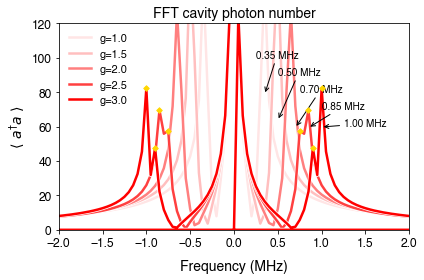

In [5]:
y1 = fftpack.fft(results[0].expect[0])
y2 = fftpack.fft(results[1].expect[0])
y3 = fftpack.fft(results[2].expect[0])
y4 = fftpack.fft(results[3].expect[0])
y5 = fftpack.fft(results[4].expect[0])
xf = fftpack.fftfreq(result.expect[0].size, d=time/steps) # takes window length and inverse of sampling rate as input

y1 = abs(y1.imag)
y2 = abs(y2.imag)
y3 = abs(y3.imag)
y4 = abs(y4.imag)
y5 = abs(y5.imag)

peaks1 = find_peaks(y1, height=[40,100], threshold=None, distance=None) #tuple containing peak positions and heights
peaks2 = find_peaks(y2, height=[40,100], threshold=None, distance=None)
peaks3 = find_peaks(y3, height=[40,100], threshold=None, distance=None)
peaks4 = find_peaks(y4, height=[40,100], threshold=None, distance=None)
peaks5 = find_peaks(y5, height=[40,100], threshold=None, distance=None)

height1 = peaks1[1]['peak_heights'] #list of the heights of the peaks
height2 = peaks2[1]['peak_heights']
height3 = peaks3[1]['peak_heights']
height4 = peaks4[1]['peak_heights']
height5 = peaks5[1]['peak_heights']

peak_pos1 = xf[peaks1[0]] #list of the peaks positions
peak_pos2 = xf[peaks2[0]]
peak_pos3 = xf[peaks3[0]]
peak_pos4 = xf[peaks4[0]]
peak_pos5 = xf[peaks5[0]]

print(peak_pos1, height1)
print(peak_pos2, height2)
print(peak_pos3, height3)
print(peak_pos4, height4)
print(peak_pos5, height5)


plt.figure(2)
plt.plot(xf, y1, color='r', linestyle='-', linewidth=2.5, alpha=0.1, label='g=1.0')
plt.plot(xf, y2, color='r', linestyle='-', linewidth=2.5, path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()], alpha=0.25, label='g=1.5')
plt.plot(xf, y3, color='r', linestyle='-', linewidth=2.5, path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()], alpha=0.5, label='g=2.0')
plt.plot(xf, y4, color='r', linestyle='-', linewidth=2.5, path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()], alpha=0.75, label='g=2.5')
plt.plot(xf, y5, color='r', linestyle='-', linewidth=2.5, path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()], alpha=1, label='g=3.0')
plt.scatter(peak_pos1, height1, color = 'gold', s = 15, marker = 'D', zorder=6)
plt.scatter(peak_pos2, height2, color = 'gold', s = 15, marker = 'D', zorder=6)
plt.scatter(peak_pos3, height3, color = 'gold', s = 15, marker = 'D', zorder=6)
plt.scatter(peak_pos4, height4, color = 'gold', s = 15, marker = 'D', zorder=6)
plt.scatter(peak_pos5, height5, color = 'gold', s = 15, marker = 'D', zorder=6)
plt.xlim(-2, 2)
plt.ylim(0, 120)
plt.title('FFT cavity photon number', fontsize = 14)
plt.ylabel(r'$\langle\ a^\dag a \ \rangle$', fontsize = 14)
plt.xlabel('Frequency (MHz)', labelpad = 10, fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fancybox=False, edgecolor='w', fontsize=11, loc="upper left")
plt.annotate('0.35 MHz',xy=(0.35,78.82311798),arrowprops=dict(arrowstyle='->'),xytext=(0.25,100))
plt.annotate('0.50 MHz',xy=(0.5,63.70521292),arrowprops=dict(arrowstyle='->'),xytext=(0.5,90))
plt.annotate('0.70 MHz',xy=(0.7,59.40153643),arrowprops=dict(arrowstyle='->'),xytext=(0.75,80))
plt.annotate('0.85 MHz',xy=(0.85,59.30466472),arrowprops=dict(arrowstyle='->'),xytext=(1.00,70))
plt.annotate('1.00 MHz',xy=(1,59.76414857),arrowprops=dict(arrowstyle='->'),xytext=(1.25,60))
plt.tight_layout()
plt.savefig('fft adag a.png', format = 'png', dpi = 900)

In [6]:
def locpeaks(ydata):

    # for local maxima
    peak_indx = argrelextrema(ydata, np.greater)[0] # zero is necessary to flatten tuple
    peak_pos = peak_indx /2000 * 20 
    peak_data = ydata[argrelextrema(ydata, np.greater)[0]]
    
    # checking that if a maxima occurs at t=0, it is included
    if np.argmax(ydata) == 0:
        peak_times = np.insert(peak_pos, 0, 0)
        peak_vals = np.insert(peak_data, 0, ydata[0])    
    else: 
        peak_times = peak_pos
        peak_vals = peak_data
        
    
    # for local minima
    trough_indx = argrelextrema(ydata, np.less)[0] # zero is necessary to flatten tuple
    trough_pos = trough_indx /2000 * 20 
    trough_data = ydata[argrelextrema(ydata, np.less)[0]]
        
    # checking that if a minima occurs at t=0, it is included
    if np.argmin(ydata) == 0:
        trough_times = np.insert(trough_pos, 0, 0)
        trough_vals = np.insert(trough_data, 0, ydata[0]) 
    else: 
        trough_times = trough_pos
        trough_vals = trough_data
    
    return [peak_times, peak_vals], [trough_times, trough_vals]

phot_peaks, phot_troughs = locpeaks(n_phot_list)
inver13_peaks, inver13_troughs = locpeaks(inver13_list)
spin_spin13_peaks, spin_spin13_troughs = locpeaks(spin_spin13_list)
spin13_phot_peaks, spin13_phot_troughs = locpeaks(spin13_phot_list)


In [7]:
def curvefit(points):

    # fitting functions
    def exp(x, a, b, c):
        return a*np.exp(-b*x) + c # exponential decay

    def gaus(x, a, b, c):
        return a*np.exp(-(x-b)**2 /c) # gaussian envelope

    # optimization of fit parameter using curve_fit
    popt1, pcov1 = curve_fit(exp, points[0], points[1], maxfev = 1500) #points[0] and points[1] are x and y data respectively
    popt2, pcov2 = curve_fit(gaus, points[0], points[1], maxfev = 5000000)

    print(popt1)
    
    # generating fit data for plotting
    fit1 = [] # ydata for exponential fit function
    fit2 = [] # ydata for gaussian fit function
    for i in tlist:
        fit1.append(exp(i, popt1[0], popt1[1], popt1[2])) # calculate y values of exponential fit function at each time step and append to ydata list
        fit2.append(gaus(i, popt2[0], popt2[1], popt2[2])) # calculate y values of gaussian fit function at each time step and append to ydata list

    return fit1, fit2

phot_peaks_fit1, phot_peaks_fit2 = curvefit(phot_peaks)
inver13_peaks_fit1, inver13_peaks_fit2 = curvefit(inver13_peaks)
spin_spin13_peaks_fit1, spin_spin13_peaks_fit2 = curvefit(spin_spin13_peaks)
spin13_phot_peaks_fit1, spin13_phot_peaks_fit2 = curvefit(spin13_phot_peaks)
spin13_phot_troughs_fit1, spin13_phot_troughs_fit2 = curvefit(spin13_phot_troughs)


[9.99685676e-01 1.00081024e-01 1.86610323e-04]
[ 1.99971993  0.10022153 -0.99882357]
[9.99859960e-01 1.00221536e-01 5.88219559e-04]
[4.83585485e-01 1.00090993e-01 5.75924071e-05]
[-5.17031627e-01  9.99256845e-02  2.42518704e-04]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


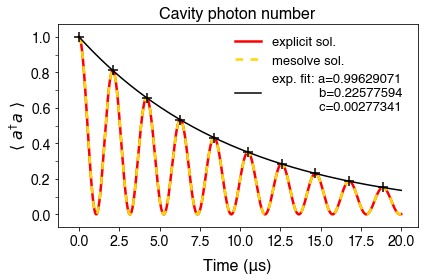

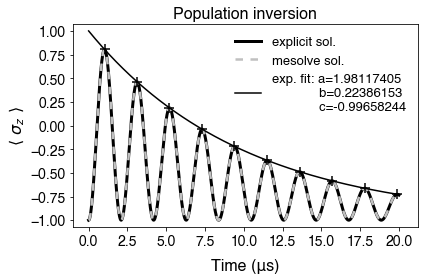

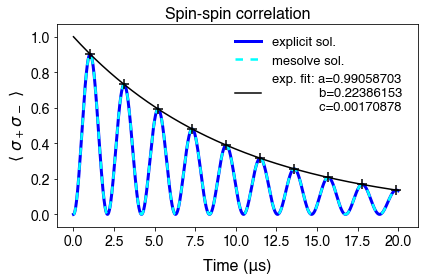

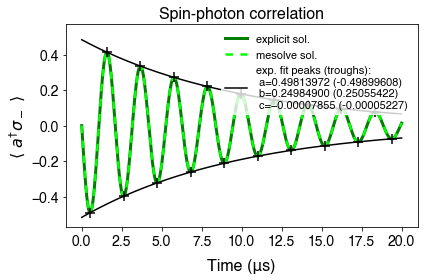

In [8]:
## Visualization

fig, ax = plt.subplots(figsize=(6,4))
plt.figure(1)
plt.plot(tlist, n_phot_list, color='r', linestyle='-', linewidth=2.5, zorder=0, label='explicit sol.')
plt.plot(tlist, results[1].expect[0], color='gold', linestyle='--',dashes=(3, 3), linewidth=2.5, zorder=0, label='mesolve sol.')
plt.scatter(phot_peaks[0], phot_peaks[1], color='k', marker='+', s=90, linewidth=1.5, zorder=1)
plt.plot(tlist, phot_peaks_fit1, color='k', linestyle='-', linewidth='1.5', zorder=2, label= "exp. fit: a=0.99629071 \n             b=0.22577594 \n             c=0.00277341")
plt.ylim([-0.07, 1.07])
plt.title('Cavity photon number', fontsize = 16)
plt.ylabel(r'$\langle\ a^\dag a \ \rangle$', fontsize = 16)
plt.xlabel('Time (μs)', labelpad = 10, fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax.xaxis.set_major_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=3)
plt.legend(fancybox=False, edgecolor='w', fontsize=13)
plt.tight_layout()
plt.savefig('adag a.png', format = 'png', dpi = 900) 


plt.figure(figsize=(6,4))
plt.figure(2)
plt.plot(tlist, inver13_list, color='k', linestyle='-', linewidth=3, zorder=0, label='explicit sol.')
plt.plot(tlist, results[1].expect[1], color='silver', linestyle='--',dashes=(3, 3), linewidth=2.5, zorder=0, label='mesolve sol.')
plt.scatter(inver13_peaks[0], inver13_peaks[1], color='k', marker='+', s=90, linewidth=1.5, zorder=1)
plt.plot(tlist, inver13_peaks_fit1, color='k', linestyle='-', linewidth='1.5', zorder=2, label= "exp. fit: a=1.98117405 \n             b=0.22386153 \n             c=-0.99658244")
plt.ylim([-1.07, 1.07])
plt.title('Population inversion', fontsize = 16)
plt.ylabel(r'$\langle\ \sigma_z \ \rangle$', fontsize = 16)
plt.xlabel('Time (μs)', labelpad = 10, fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax.xaxis.set_major_locator(MultipleLocator(2.5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))
#ax.tick_params(which='minor', length=3)
plt.legend(fancybox=False, edgecolor='w', fontsize=13)
plt.tight_layout()
plt.savefig('sigmaz.png', format = 'png', dpi = 900) 


plt.figure(figsize=(6,4))
plt.figure(3)
plt.plot(tlist, spin_spin13_list, color='b', linestyle='-', linewidth=3, zorder=0, label='explicit sol.')
plt.plot(tlist, results[1].expect[2], color='cyan', linestyle='--',dashes=(3, 3), linewidth=2.5, zorder=0, label='mesolve sol.')
plt.scatter(spin_spin13_peaks[0], spin_spin13_peaks[1], color='k', marker='+', s=90, linewidth=1.5, zorder=1)
plt.plot(tlist, spin_spin13_peaks_fit1, color='k', linestyle='-', linewidth='1.5', zorder=2, label="exp. fit: a=0.99058703 \n             b=0.22386153 \n             c=0.00170878")
plt.ylim([-0.07, 1.07])
plt.title('Spin-spin correlation', fontsize = 16)
plt.ylabel(r'$\langle\ \sigma_+ \sigma_- \ \rangle$', fontsize = 16)
plt.xlabel('Time (μs)', labelpad = 10, fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax.xaxis.set_major_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=3)
plt.legend(fancybox=False, edgecolor='w', fontsize=13)
plt.tight_layout()
plt.savefig('sigmap sigmam.png', format = 'png', dpi = 900) 


plt.figure(figsize=(6,4))
plt.figure(4)
plt.plot(tlist, spin13_phot_list, color='g', linestyle='-', linewidth=3, zorder=0, label='explicit sol.')
plt.plot(tlist, results[1].expect[3].imag, color='lime', linestyle='--',dashes=(3, 3), linewidth=2.5, zorder=0, label='mesolve sol.')
plt.scatter(spin13_phot_peaks[0], spin13_phot_peaks[1], color='k', marker='+', s=90, linewidth=1.5, zorder=1)
plt.scatter(spin13_phot_troughs[0], spin13_phot_troughs[1], color='k', marker='+', s=90, linewidth=1.5, zorder=1)
plt.plot(tlist, spin13_phot_peaks_fit1, color='k', linestyle='-', linewidth='1.5', zorder=2, label="exp. fit peaks (troughs): \n a=0.49813972 (-0.49899608) \n b=0.24984900 (0.25055422) \n c=−0.00007855 (-0.00005227)")
plt.plot(tlist, spin13_phot_troughs_fit1, color='k', linestyle='-', linewidth='1.5', zorder=2)
plt.ylim([-0.57, 0.57])
plt.title('Spin-photon correlation', fontsize = 16)
plt.ylabel(r'$\langle\ a^\dag \sigma_- \ \rangle$', fontsize = 16)
plt.xlabel('Time (μs)', labelpad = 10, fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax.xaxis.set_major_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=3)
plt.legend(fancybox=False, edgecolor='w', fontsize=11)
plt.tight_layout()
plt.savefig('adag sigmam.png', format = 'png', dpi = 900)  

plt.show()




In [9]:
locpeaks(n_phot_list)

([array([ 0.  ,  2.09,  4.19,  6.28,  8.38, 10.47, 12.57, 14.66, 16.76,
         18.85]),
  array([1.        , 0.81090707, 0.65762918, 0.53328673, 0.43247428,
         0.35071037, 0.28440526, 0.23063997, 0.18703079, 0.15167663])],
 [array([ 1.07,  3.16,  5.26,  7.35,  9.45, 11.54, 13.64, 15.73, 17.83,
         19.92]),
  array([ 5.38440901e-07,  2.62038362e-05,  2.96070711e-06,  9.83504020e-06,
          5.32883313e-06,  2.95718022e-06,  6.82468695e-06,  5.26293058e-07,
          7.39238647e-06, -1.39913868e-09])])